# Assignment 4: Pipelines and Hyperparameter Tuning (32 total marks)
### Due: November 22 at 11:59pm

### Name: Carissa Chung

### In this assignment, you will be putting together everything you have learned so far. You will need to find your own dataset, do all the appropriate preprocessing, test different supervised learning models and evaluate the results. More details for each step can be found below.

### You will also be asked to describe the process by which you came up with the code. More details can be found below. Please cite any websites or AI tools that you used to help you with this assignment.

## Import Libraries

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from geopy.distance import geodesic
import time
from IPython.display import clear_output 

## Step 1: Data Input (4 marks)

Import the dataset you will be using. You can download the dataset onto your computer and read it in using pandas, or download it directly from the website. Answer the questions below about the dataset you selected. 

To find a dataset, you can use the resources listed in the notes. The dataset can be numerical, categorical, text-based or mixed. If you want help finding a particular dataset related to your interests, please email the instructor.

**You cannot use a dataset that was used for a previous assignment or in class**

In [24]:
# Import dataset (1 mark)
data = pd.read_csv(r'C:\Users\caris\Documents\ENSF 611\Assignment 4\train_sample.csv')
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,3/14/2016 17:24,3/14/2016 17:32,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,6/12/2016 0:43,6/12/2016 0:54,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,1/19/2016 11:35,1/19/2016 12:10,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,4/6/2016 19:32,4/6/2016 19:39,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,3/26/2016 13:30,3/26/2016 13:38,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Questions (3 marks)

1. (1 mark) What is the source of your dataset?
1. (1 mark) Why did you pick this particular dataset?
1. (1 mark) Was there anything challenging about finding a dataset that you wanted to use?

*ANSWER HERE*
1. The dataset can be found on Kaggle: https://www.kaggle.com/competitions/nyc-taxi-trip-duration
2. I chose this dataset as I believe it would be good practice on encoding various columns (datetime columns, NYC neighbourhoods, etc).
3. The challenge about finding a dataset was how large some datasets can be. A similar NYC taxi dataset that I had found was 11gb which was too large to download. So I had to find other similar datasets that were more reasonable in size so that it could be downloaded.

## Step 2: Data Processing (5 marks)

The next step is to process your data. Implement the following steps as needed.

In [25]:
# Clean data (if needed)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  9999 non-null   object 
 1   vendor_id           9999 non-null   int64  
 2   pickup_datetime     9999 non-null   object 
 3   dropoff_datetime    9999 non-null   object 
 4   passenger_count     9999 non-null   int64  
 5   pickup_longitude    9999 non-null   float64
 6   pickup_latitude     9999 non-null   float64
 7   dropoff_longitude   9999 non-null   float64
 8   dropoff_latitude    9999 non-null   float64
 9   store_and_fwd_flag  9999 non-null   object 
 10  trip_duration       9999 non-null   int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 859.4+ KB


In [26]:
# Check for null values
data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [27]:
# Convert 'pickup_timedate' and 'dropoff_timedate' columns to datetime
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  9999 non-null   object        
 1   vendor_id           9999 non-null   int64         
 2   pickup_datetime     9999 non-null   datetime64[ns]
 3   dropoff_datetime    9999 non-null   datetime64[ns]
 4   passenger_count     9999 non-null   int64         
 5   pickup_longitude    9999 non-null   float64       
 6   pickup_latitude     9999 non-null   float64       
 7   dropoff_longitude   9999 non-null   float64       
 8   dropoff_latitude    9999 non-null   float64       
 9   store_and_fwd_flag  9999 non-null   object        
 10  trip_duration       9999 non-null   int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 859.4+ KB


In [28]:
# Implement preprocessing steps. Remember to use ColumnTransformer if more than one preprocessing method is needed

#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
data['weekday'] = data.pickup_datetime.dt.day_name()
data['month'] = data.pickup_datetime.dt.month
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour

In [29]:
# Calculate distance between pickup and dropoff coordinates using geodesic
distance = []
for index in data['pickup_latitude'].index:
    clear_output()
    print(index)
    distance.append(geodesic((data['pickup_latitude'].iloc[index],data['pickup_longitude'].iloc[index]),(data['dropoff_latitude'].iloc[index],data['dropoff_longitude'].iloc[index])).miles)
data['distance'] = distance

9998


In [30]:
# Calculate Speed in miles/hr for further insights
data['speed'] = (data.distance/(data.trip_duration/3600))

In [31]:
# Clustering
coords = np.vstack((data[['pickup_latitude', 'pickup_longitude']].values,
                    data[['dropoff_latitude', 'dropoff_longitude']].values))

In [32]:
from sklearn.cluster import MiniBatchKMeans
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])
data.loc[:, 'pickup_cluster'] = kmeans.predict(data[['pickup_latitude', 'pickup_longitude']])
data.loc[:, 'dropoff_cluster'] = kmeans.predict(data[['dropoff_latitude', 'dropoff_longitude']])

c:\Users\caris\Anaconda3\envs\ensf-611\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


c:\Users\caris\Anaconda3\envs\ensf-611\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(
c:\Users\caris\Anaconda3\envs\ensf-611\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(


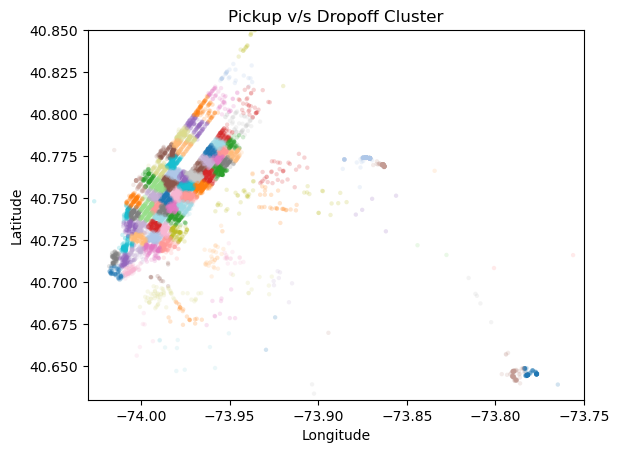

In [33]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(data.pickup_longitude.values, data.pickup_latitude.values, s=10, lw=0,
           c=data.pickup_cluster.values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Pickup v/s Dropoff Cluster')
plt.show()

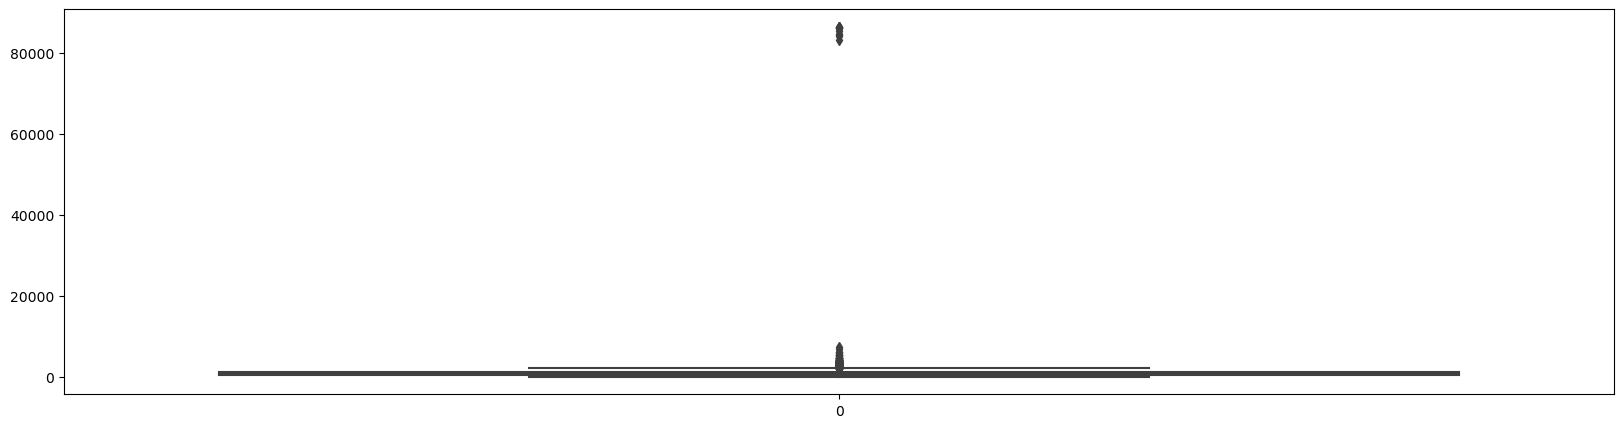

In [34]:
# Exploratory Data Analysis (to help determine which features are important)

# Possible outliers (trip duration > 100000)
plt.figure(figsize = (20,5))
sns.boxplot(data.trip_duration)
plt.show()

In [35]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,max(data.trip_duration),3600))).count()

trip_duration
(1, 3601]         9934
(3601, 7201]        53
(7201, 10801]        1
(10801, 14401]       0
(14401, 18001]       0
(18001, 21601]       0
(21601, 25201]       0
(25201, 28801]       0
(28801, 32401]       0
(32401, 36001]       0
(36001, 39601]       0
(39601, 43201]       0
(43201, 46801]       0
(46801, 50401]       0
(50401, 54001]       0
(54001, 57601]       0
(57601, 61201]       0
(61201, 64801]       0
(64801, 68401]       0
(68401, 72001]       0
(72001, 75601]       0
(75601, 79201]       0
(79201, 82801]       0
Name: trip_duration, dtype: int64

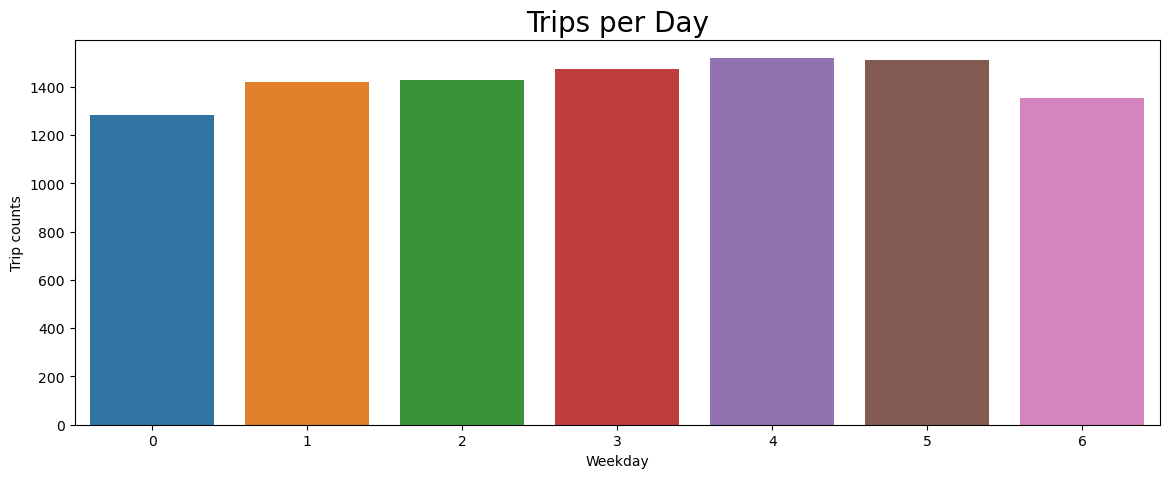

In [36]:
plt.figure(figsize=(14, 5))
sns.countplot(x='weekday_num', data=data)
plt.xlabel('Weekday')
plt.ylabel('Trip counts')
plt.title('Trips per Day', fontsize=20)
plt.show()

c:\Users\caris\Anaconda3\envs\ensf-611\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


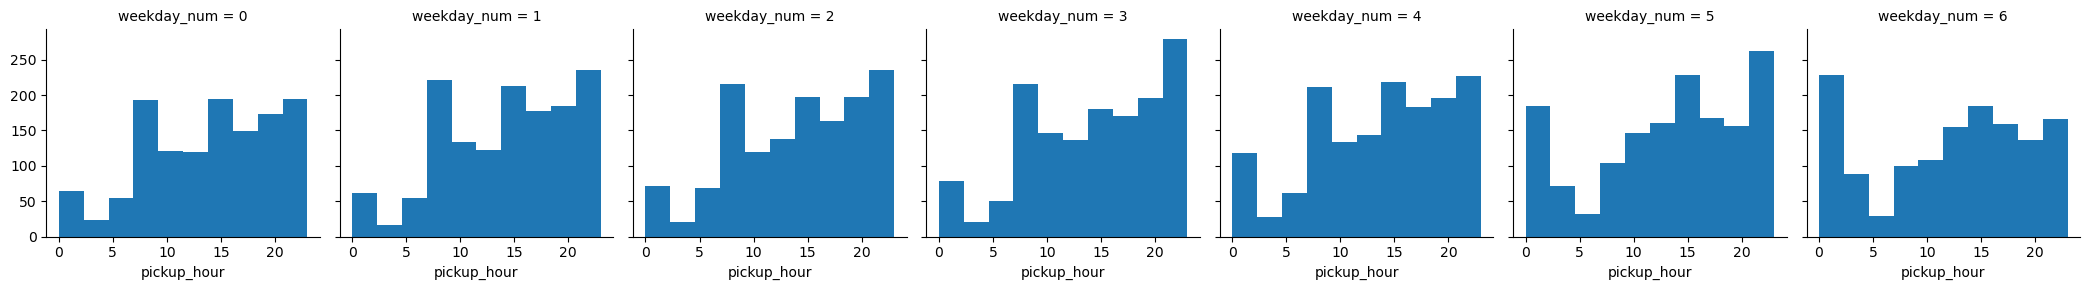

In [37]:
n = sns.FacetGrid(data, col='weekday_num')
n.map(plt.hist, 'pickup_hour')
plt.show()

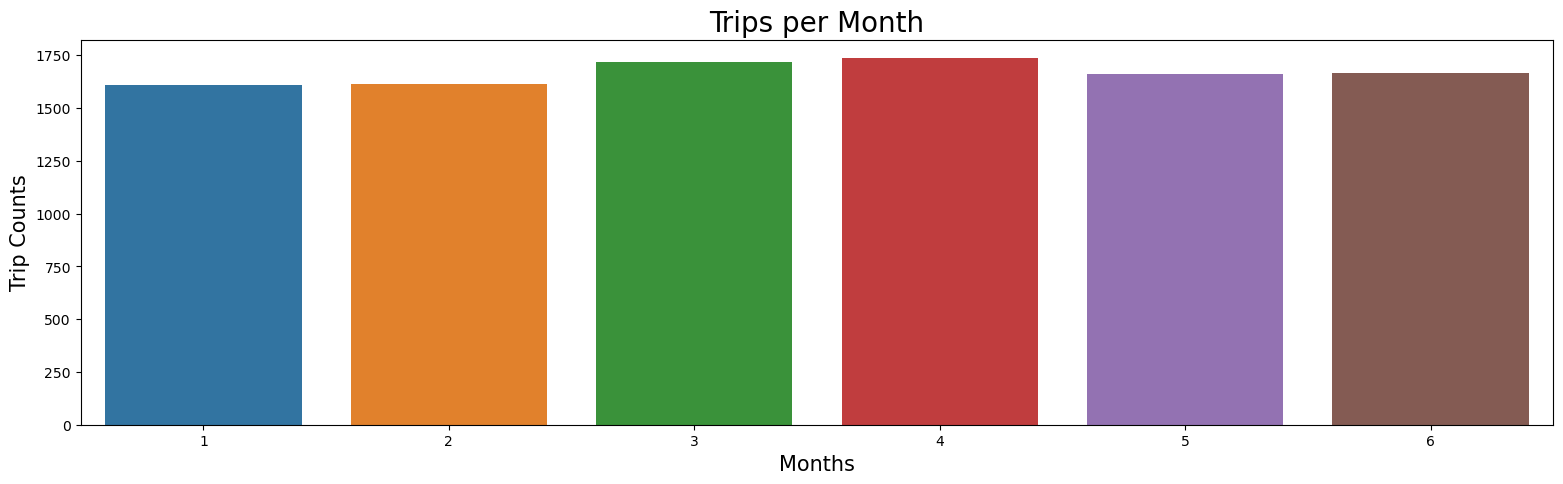

In [38]:
plt.figure(figsize = (19,5))
sns.countplot(x='month', data=data)
plt.ylabel('Trip Counts',fontsize = 15)
plt.xlabel('Months',fontsize = 15)
plt.title('Trips per Month',fontsize = 20)
plt.show()

In [39]:
# Feature Selection
data.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
weekday                       object
month                          int32
weekday_num                    int32
pickup_hour                    int32
distance                     float64
speed                        float64
pickup_cluster                 int32
dropoff_cluster                int32
dtype: object

In [40]:
data.shape

(9999, 19)

In [41]:
X = data.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'weekday'])
y = data['trip_duration']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 7294)

In [42]:
# Show X and y
X.head()

,vendor_id,passenger_count,month,weekday_num,pickup_hour,distance,speed,pickup_cluster,dropoff_cluster
0,2,1,3,0,17,0.933406,7.385193,92,52
1,1,1,6,6,0,1.123849,6.102349,20,47
2,2,1,1,1,11,3.964154,6.718905,9,68
3,2,1,4,2,19,0.921886,7.736109,94,0
4,2,1,3,5,13,0.737591,6.104201,40,18


In [43]:

y.head()

0     455
1     663
2    2124
3     429
4     435
Name: trip_duration, dtype: int64

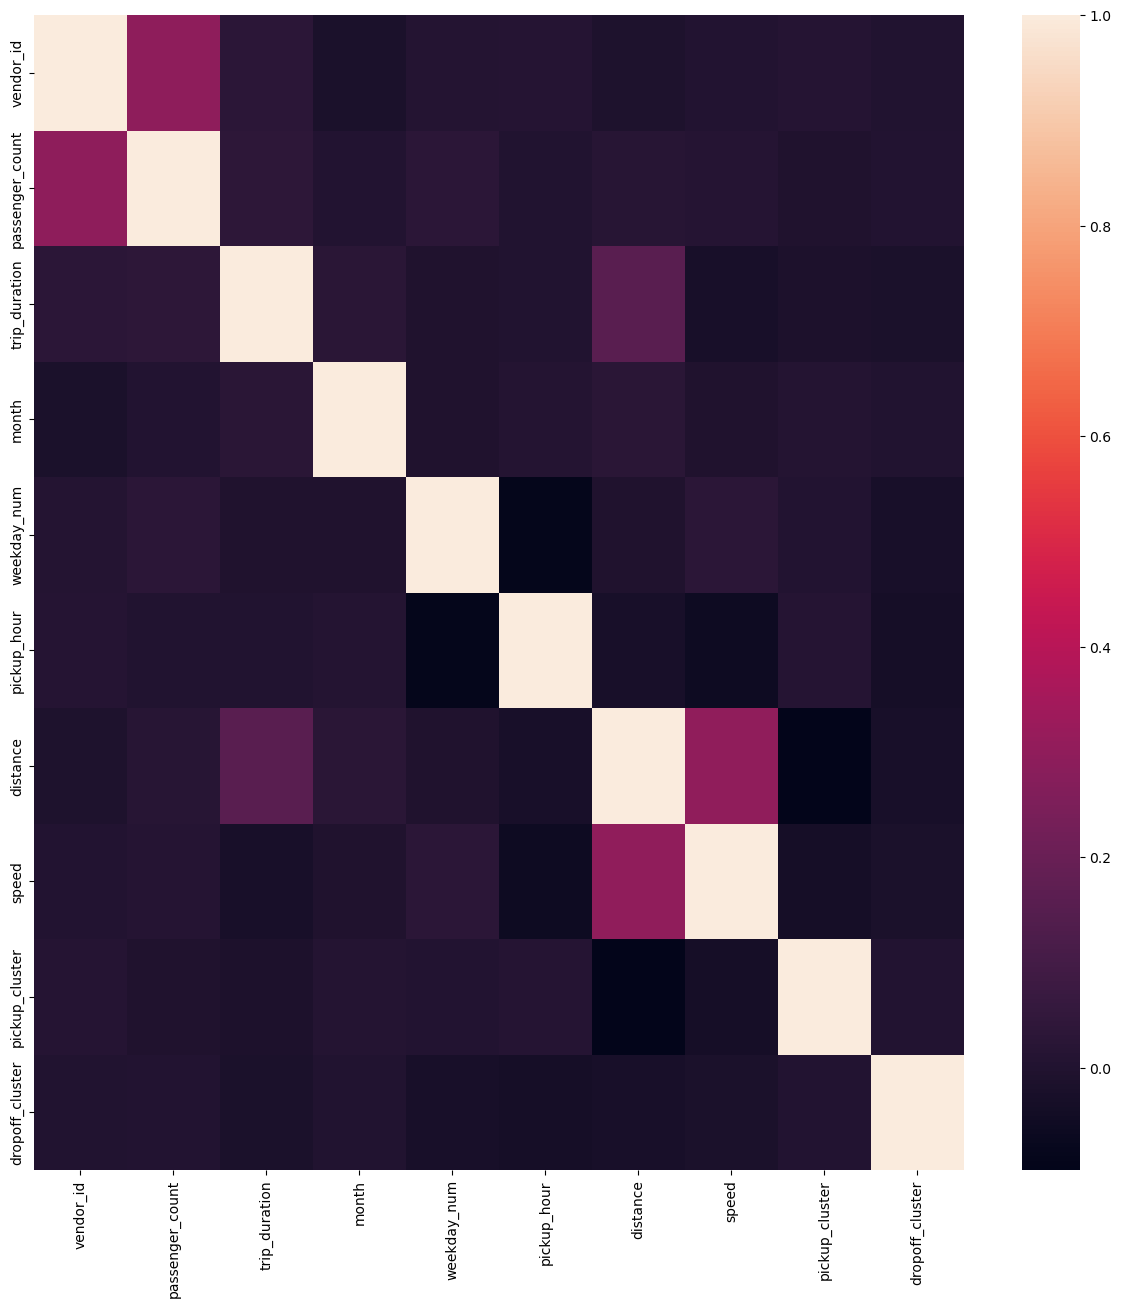

In [44]:
plt.figure(figsize=(15,15))
result = data.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'weekday'])
sns.heatmap(result.corr());

### Questions (2 marks)

1. (1 mark) Were there any missing/null values in your dataset? If yes, how did you replace them and why? If no, describe how you would've replaced them and why.
2. (1 mark) What type of data do you have? What preprocessing methods would you have to apply based on your data types?

*ANSWER HERE*
1. There were no missing or null values in the dataset. If there were enough null values (majority of the values of a feature), I would drop the column. If there were only a few null or missing values, I would evaluate the meaning of the feature and decide whether the null/missing values should be replaced with a 0, the mean, median, etc. based on which would be most appropriate.
2. The dataset contains continuous numerical data. Based on the data types, the objects would need to be converted to a data type that would be able to be processed by the model. For example, the date/features would need to be converted to datetime datatypes and encoded to ensure that the values of the features are numerical. In addition, any string values (e.g., feature "weekday") would need to be encoded or dropped prior to training the model.

## Step 3: Implement Machine Learning Model (11 marks)

In this section, you will implement three different supervised learning models (one linear and two non-linear) of your choice. You will use a pipeline to help you decide which model and hyperparameters work best. It is up to you to select what models to use and what hyperparameters to test. You can use the class examples for guidance. You must print out the best model parameters and results after the grid search.

In [45]:
# Implement pipeline and grid search here. Can add more code blocks if necessary
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

print(X.shape)
print(y.shape)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=7294)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=7294)

# Define the models
ridge_model = Ridge()
rf_model = RandomForestRegressor()
gb_model = GradientBoostingRegressor()

# Define the parameter grids
ridge_param_grid = {'Ridge Regression__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
rf_param_grid = {'Random Forest__n_estimators': [50, 100, 200], 'Random Forest__max_depth': [5, 10, 20]}
gb_param_grid = {'Gradient Boosting__n_estimators': [50, 100, 200], 'Gradient Boosting__max_depth': [3, 5, 7], 'Gradient Boosting__learning_rate': [0.001, 0.01, 0.1]}

# Combine models and grids into a list
models_and_grids = [
    (ridge_model, ridge_param_grid, 'Ridge Regression'),
    (rf_model, rf_param_grid, 'Random Forest'),
    (gb_model, gb_param_grid, 'Gradient Boosting')
]

# Iterate over models and grids
for model, param_grid, model_name in models_and_grids:
    # Create a pipeline for each model
    model_pipeline = Pipeline([
        (model_name, model)
    ])

    # Perform GridSearchCV
    grid_search = GridSearchCV(model_pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    # Print the best parameters and evaluate the model on the validation set
    best_model = grid_search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    mse_val = mean_squared_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)
    print(f'{model_name}: Best Parameters - {grid_search.best_params_}, \nMSE on Validation Set: {mse_val}, R2 Score on Validation Set: {r2_val}')

    # Evaluate the model on the test set
    y_test_pred = best_model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f'MSE on Test Set: {mse_test}, R2 Score on Test Set: {r2_test}')

(9999, 9)
(9999,)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Ridge Regression: Best Parameters - {'Ridge Regression__alpha': 100.0}, 
MSE on Validation Set: 24023042.784866445, R2 Score on Validation Set: -0.24259726607265453
MSE on Test Set: 168060.64408944218, R2 Score on Test Set: 0.6052543706146536
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Random Forest: Best Parameters - {'Random Forest__max_depth': 20, 'Random Forest__n_estimators': 50}, 
MSE on Validation Set: 54678.8285030728, R2 Score on Validation Set: 0.9971717253547592
MSE on Test Set: 11814.911203207994, R2 Score on Test Set: 0.972248799923912
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Gradient Boosting: Best Parameters - {'Gradient Boosting__learning_rate': 0.1, 'Gradient Boosting__max_depth': 3, 'Gradient Boosting__n_estimators': 200}, 
MSE on Validation Set: 13136.137025980226, R2 Score on Validation Set: 0.9993205303715513
MSE on Test Set: 8209.495227762476, R2 Scor

### Questions (5 marks)

1. (1 mark) Do you need regression or classification models for your dataset?
1. (2 marks) Which models did you select for testing and why?
1. (2 marks) Which model worked the best? Does this make sense based on the theory discussed in the course and the context of your dataset?

*ANSWER HERE*
1. Regression models should be used for the dataset since I am trying to predict a target of continuous values (i.e., trip duration).
2. Ridge Regression - the alpha parameter allows for model complexity tuning which the linear regression model does not have. The model is quick to train and predict and thus, can be used to illustrate if the data has a linear relationship or not.
</br>Random Forest - less sensitive to hyperparameter tuning compared to gradient boosting; limited by computing power (number of estimators)
</br>Gradient Boosting - won't be limited by computing power (trees trained in series); more sensitive to hyperparameter tuning
3. The random forest model worked the best since it had a really good R2 score while having a lower training time compared to the gradient boosting model. This makes sense based on the theory discussed in the course as the dataset most likely does not have a linear relationship with the trip duration. In addition, the gradient boosting model requires much more sensitive hyperparameter tuning and thus may require further iterative assessment to determine the best parameters to get the best results. However, since the training occurs in series, training this model is very time consuming and since the random forest model already produced great results, the gradient boosting model is most likely not required just to get slightly better accuracy. In addition, due to the nature of the data used, it was expected that a linear model would be too simple to predict the trip durations from the provided features.

The above decision is based on the observed test R2 score. However, if the training R2 score is very close to 1, the model may be overfitted. Thus, the model will need to be tested on more data to draw a final conclusion whether the model is well generalized or not. Based on the small amount of testing data used for this assignment, it does appear that the model is well generalized.

## Step 4: Validate Model (6 marks)

Use the testing set to calculate the testing accuracy for the best model determined in Step 3.

In [46]:
# Calculate testing accuracy (1 mark)
# see above for both validation and testing accuracies
 


### Questions (5 marks)

1. (1 mark) Which accuracy metric did you choose? 
1. (1 mark) How do these results compare to those in part 3? Did this model generalize well?
1. (3 marks) Based on your results and the context of your dataset, did the best model perform "well enough" to be used out in the real-world? Why or why not? Do you have any suggestions for how you could improve this analysis?

*ANSWER HERE*
1. R2 scores were used as the accuracy metric since this is a regression problem.
2. Although the Ridge regression model did poorly on the validation testing set, it performed well on the testing set. 
The Random Forest and Gradient Boosting models both performed well on the validation and testing set. This indicates that both models generalized well since the testing accuracies were still very high. This can be confirmed by using a larger testing data size.
3. Based on the results of the random forest and gradient boosting model, the models did perform well enough to be used out in the real-world. However, the training, validation, and testing of the models takes a long time. If possible, more computing power/parallel computing could be used to train the models quicker. In addition, alternative distance calculation methods could be used to possibly improve the accuracy of the results. The distance calculation also takes some time to compute and thus, could result in long delays when used on much larger datasets. Thus, more efficient calculation methods could be used or possible, the use of parallel computing to reduce computing times.

## Process Description (4 marks)
Please describe the process you used to create your code. Cite any websites or generative AI tools used. You can use the following questions as guidance:
1. Where did you source your code?
1. In what order did you complete the steps?
1. If you used generative AI, what prompts did you use? Did you need to modify the code at all? Why or why not?
1. Did you have any challenges? If yes, what were they? If not, what helped you to be successful?

*DESCRIBE YOUR PROCESS HERE*
1. I sourced my code from the class/lab examples. Some exploratory data analysis visualizations were sourced from seaborn documentation.
2. I completed all the steps in order. Iterative work was required to get decent results from the models. Feature engineering was completed after train/testing the model on the original dataset.
3. AI was not used to generate any code for this project.
4. Yes, there were many challenges to get good results from the models. Initially, two APIs were used (Google maps - reverse geocode, GraphHopper - calculate distance) for feature engineering. Reverse geocoding was used to convert the coordinates into neighborhoods. These categorical values were encoded and then used to train and test the model. However this produced very poor results (R2 values around 0.01). The GraphHopper API was then used to calculate the distance of each taxi trip using the pickup and dropoff coordinates. This did not improve the R2 scores. Finally decided to try clustering and other feature engineering to get the final results.

## Reflection (2 marks)
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challenging, motivating
while working on this assignment.


*ADD YOUR THOUGHTS HERE*
- It was really interesting to experience the process of designing a model based on real-world data that had not been made intentionally for machine learning teaching purposes. It was a very educational iterative process to be able to get good results from the model.
- It was very challenging to determine what features needed to be engineered or what existing features were crucial for predicting the target. It was interesting to see how the topics covered in class can be used and applied to real-world datasets.
